# Predicting Indonesian Hate Speech

Hate speech and abusive language spreading on social media need to be detected automatically to avoid conflicts between citizens. Hate speech can also come in many different form, including hate speeh toward individual, group, race, religion, or even gender. In this notebook, we will try to create a deep learning model to classify if a tweet contain hate speech based on data collected from Indonesia. The model will help understand the social dynamics between various people in the internet, the motivation behind the hate speech, and will also help twitter developer to create warning for their user before reading the tweet.

![](asset/warning.jpeg)

## Library and Setup

For our purpose, we will use keras and tensorflow to build the model. The following is the full required libraries.

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np 

# Regex
import re

# Deep Learning
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data

The data is acquired from [Ibrohim and Budi](https://www.aclweb.org/anthology/W19-3506.pdf) who use label Indonesian as hate speech. The data is crawled from Twitter for about 7 months, from March 20th, 2018 until September 10th, 2018.

The following is the description of each column:

- **Tweet**: Content of the tweet
- **HS**: Whether the tweet is a hate speech (1) or not (0)
- **Abusive**: Whether the tweet contains abusive language (1) or not (0)
- **HS_Individual**:  Whether the tweet is a hate speech toward certain individuals (1) or not (0)
- **HS_Group**: Whether the tweet is a hate speech toward certain group (1) or not (0)
- **HS_Religion**: Whether the tweet contains hate speech based on a religion (Islam, Christian, Catholic, etc.), religious organization/stream, or a particular creed 
- **HS_Race**: Whether the tweet contains hate speech based on hate speech based on a human race (human groups based on physical characteristics such as face shape, height, skin color, and others) or ethnicity (human groups based on general citizenship or shared cultural traditions in a geographical area)
- **HS_Physical**: Whether the tweet contains hate speech hate speech based on physical deficiencies/differences (e.g. shape of face, eye, and other body parts) or disability (e.g. autism, idiot, blind, deaf, etc.), either just cursing someone (or a group) with those words related to physical/disability or those that are truly experienced by those who are the target of the hate speech
- **HS_Gender**:  Whether the tweet contains hate speech based on gender (male and female), cursing someone (or a group) using words that are degrading to gender (e.g.: gigolo, bitch, etc.), or deviant sexual orientation (e.g.: homosexual, lesbian, etc.)
- **HS_Other**: Whether the tweet contains hate speech in the form of swearing/ridicule using crude words/phrases or other slanders/incitement which are not related to the four groups previously explained.
- **HS_Weak**: Does the tweet classified as a weak hate speech?
- **HS_Moderate**: Does the tweet classified as a moderate hate speech?
- **HS_Strong**: Does the tweet classified as a strong hate speech?


In [2]:
df_hate = pd.read_csv('data/re_dataset.csv')

df_hate.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


# Text Preprocessing

Before we build the model, we will start by cleansing the text using the following process:

- Lowercase all texts
- Remove the word `user` because they are used to mask mention name
- Remove the word `rt`
- Remove newline (`\n`)
- Remove encoded emoticon
- Remove hashtag
- Remove numbers
- Remove punctuation
- Remove extra whitespace

In [3]:
df_clean = df_hate.copy()
df_clean['Tweet'] = list(map(lambda x: re.sub('\\buser\\b', '' , x.lower()), df_clean['Tweet']))
df_clean['Tweet'] = list(map(lambda x: re.sub('\\brt\\b', '' , x), df_clean['Tweet']))

# Remove newline
df_clean['Tweet'] = list(map(lambda x: re.sub("[\\\]n", ' ' , x), df_clean['Tweet']))

# Remove encoded emoticon
df_clean['Tweet'] = list(map(lambda x: re.sub('x.*? |x.*[\\\]|x.*', ' ' , x), df_clean['Tweet']))

# Remove hashtag
df_clean['Tweet'] = list(map(lambda x: re.sub("#.*? |#.*?[!'#S%&'()*+,-./:;<=>?@[/]^_{|}~]|#.*", " ", x), df_clean['Tweet']))

# Remove numbers
df_clean['Tweet'] = list(map(lambda x: re.sub('\d+', ' ' , x), df_clean['Tweet']))

# Remove Punctuation
df_clean['Tweet'] = list(map(lambda x: re.sub('"', ' ' , x), df_clean['Tweet']))
df_clean['Tweet'] = list(map(lambda x: re.sub("[\\[\\]!'#S%&'()*+,-.\\/:;<=>?@^_{|}~\\\]", ' ' , x).strip(), df_clean['Tweet']))

# Remove extra whitespace
df_clean['Tweet'] = list(map(lambda x: re.sub(" +", ' ' , x), df_clean['Tweet']))

df_clean.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,disaat semua cowok berusaha melacak perhatian ...,1,1,1,0,0,0,0,0,1,1,0,0
1,siapa yang telat ngasih tau elu edan sarap gue...,0,1,0,0,0,0,0,0,0,0,0,0
2,kadang aku berfikir kenapa aku tetap percaya p...,0,0,0,0,0,0,0,0,0,0,0,0
3,aku itu aku ku tau matamu sipit tapi diliat da...,0,0,0,0,0,0,0,0,0,0,0,0
4,kaum cebong kapir udah keliatan dongoknya dari...,1,1,0,1,1,0,0,0,0,0,1,0


## Word Count

Before we continue, we will check the number of words for each tweet after the cleansing.

In [4]:
word_count = pd.Series(list(map(lambda x: len(x.split(" ")), df_clean['Tweet'])))

word_count.describe()

count    13169.000000
mean        15.752601
std         10.239329
min          1.000000
25%          8.000000
50%         14.000000
75%         21.000000
max         69.000000
dtype: float64

The maximum number of words for a tweet is 69. Some tweets contain only a single word, let's check some of them.

In [5]:
df_clean[ word_count == 1]

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
158,bebal,0,0,0,0,0,0,0,0,0,0,0,0
182,,0,0,0,0,0,0,0,0,0,0,0,0
288,,1,1,0,1,0,0,0,0,1,0,1,0
318,,0,0,0,0,0,0,0,0,0,0,0,0
354,cina,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12682,,0,0,0,0,0,0,0,0,0,0,0,0
12788,,0,0,0,0,0,0,0,0,0,0,0,0
12943,mampus,1,1,1,0,0,0,0,0,1,1,0,0
12952,,0,0,0,0,0,0,0,0,0,0,0,0


Turns out we there are some of them that has empty string. We will remove this data first.

In [6]:
df_clean = df_clean[ df_clean['Tweet'] != '']

df_clean.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,disaat semua cowok berusaha melacak perhatian ...,1,1,1,0,0,0,0,0,1,1,0,0
1,siapa yang telat ngasih tau elu edan sarap gue...,0,1,0,0,0,0,0,0,0,0,0,0
2,kadang aku berfikir kenapa aku tetap percaya p...,0,0,0,0,0,0,0,0,0,0,0,0
3,aku itu aku ku tau matamu sipit tapi diliat da...,0,0,0,0,0,0,0,0,0,0,0,0
4,kaum cebong kapir udah keliatan dongoknya dari...,1,1,0,1,1,0,0,0,0,0,1,0


# Train-Test Split
This step is where we will split our data into 2 separate dataset: training dataset and testing dataset. We will use 80% of the data as training dataset. For our purpose, we will predict if a tweet belong to hate speech based on the `HS` label.

- Training Dataset: Dataset that will be used to train the machine learning model
- Testing Dataset: Dataset that will be used to evaluate the performance of the model and check if the model can predict new unseen data.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df_clean['Tweet'], df_clean['HS'], test_size = 0.2, random_state = 100)

print("Number of Train Data:", len(x_train))
print("Number of Train Data:", len(x_test))

Number of Train Data: 10496
Number of Train Data: 2625


Let's check the class imbalance from the target variable.

In [8]:
pd.DataFrame(y_train).value_counts(normalize = True)

HS
0     0.577363
1     0.422637
dtype: float64

The class is quite balanced so we are good to go.

# Tokenization

We will check how many unique words that we have in our corpus/collection of texts in data train. This will help us determine how many words that we will use for the vocabulary of the input data.

In [9]:
text_review = 'a'
for i in range(len(x_train)):
    text_review = text_review + x_train.iloc[i]

len(set(text_review.split()))

30218

We have momre than 30000+ unique words from our training set.

We will transform the text data into token using tokenizer from keras library. This process is called tokenization because each sentence will broken down into words/terms. We will only take the **top 2500** words from the training set because if we use all the unique words the model will be easier to overfit.

In [10]:
num_words = 2500

tokenizer = Tokenizer(num_words = num_words, split = ' ')
tokenizer.fit_on_texts(x_train)

We will apply the tokenizer to both the training and testing dataset.

In [11]:
x_train_token = tokenizer.texts_to_sequences(x_train)
x_test_token = tokenizer.texts_to_sequences(x_test)

We will limit the length of the sequence to 100 token. Current twitter policy is that the maximum number of characters is 280 so I think it will be hard to get more than 100 words per tweet, which also proven by our previous step on which we have observed that the maximum number of words after being cleansed is only 69.

In [12]:
maxlen = 100

x_train_token = pad_sequences(x_train_token, maxlen = maxlen, padding='pre', truncating='post')
x_test_token = pad_sequences(x_test_token, maxlen = maxlen, padding='pre', truncating='post')

# Model Architecture

The model will use embedding layer to process the input text. In a variety of deep learning frameworks such as Keras, the embedding layer aims to train text data into numerical vectors which represent the closeness of the meaning of each word. The context and feature of the text will be extracted using the recurrent network of LSTM layer. Finally, the probability of the tweet belong to a hate speech will be presented by the output layer, which is transformed using sigmoid function.

In [13]:
tf.random.set_seed(123)

model = Sequential(name = 'hatespeech_binary')

# Embedding layer top map the words into
model.add(Embedding(input_dim = num_words, input_length = maxlen, output_dim = 32))

# LSTM layer to extract sequential features from text
model.add(LSTM(units = 16, return_sequences= False))

# Output Layer
model.add(Dense(units = 1, activation = "sigmoid"))

model.summary()

Model: "hatespeech_binary"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           80000     
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 83,153
Trainable params: 83,153
Non-trainable params: 0
_________________________________________________________________


# Model Fitting

We will use the Adam optimizer with learning rate of 0.001. To monitor the training progress, we use the accuracy and the AUC metrics as additional metrics. To prevent overfitting and stop the training early, we make early stopping policy where the model will not continue the training after no improvement in validation loss for 2 consecutive epochs. 

In [14]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=['acc', tf.metrics.AUC()])

epochs = 10
batch_size = 128

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

history = model.fit(x_train_token, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test_token, y_test), callbacks = callback, verbose = 1)

Epoch 1/10
82/82 [==============================] - 78s 862ms/step - loss: 0.6714 - acc: 0.5810 - auc: 0.6001 - val_loss: 0.5176 - val_acc: 0.7474 - val_auc: 0.8783
Epoch 2/10
82/82 [==============================] - 71s 864ms/step - loss: 0.4668 - acc: 0.8170 - auc: 0.8980 - val_loss: 0.3974 - val_acc: 0.8423 - val_auc: 0.9180
Epoch 3/10
82/82 [==============================] - 72s 875ms/step - loss: 0.3405 - acc: 0.8762 - auc: 0.9448 - val_loss: 0.3646 - val_acc: 0.8423 - val_auc: 0.9208
Epoch 4/10
82/82 [==============================] - 71s 862ms/step - loss: 0.2887 - acc: 0.8886 - auc: 0.9531 - val_loss: 0.3582 - val_acc: 0.8476 - val_auc: 0.9207
Epoch 5/10
82/82 [==============================] - 37s 447ms/step - loss: 0.2505 - acc: 0.9042 - auc: 0.9634 - val_loss: 0.3683 - val_acc: 0.8484 - val_auc: 0.9181
Epoch 6/10
82/82 [==============================] - 18s 219ms/step - loss: 0.2282 - acc: 0.9164 - auc: 0.9677 - val_loss: 0.3757 - val_acc: 0.8514 - val_auc: 0.9167


In [15]:
df_history = pd.DataFrame(history.history).reset_index(drop = True)
df_history['epoch'] = range(1, df_history.shape[0]+1)

tf.keras.models.save_model(model, "output/model_binary.hdf5")
df_history.to_csv("output/binary_history.csv", index = False)

I also have saved the trained model in case you don't want to wait the training.

In [16]:
df_history = pd.read_csv("output/binary_history.csv")
model = tf.keras.models.load_model("output/model_binary.hdf5")

Let's visualize the training progress. The model keep getting better in training data, indicated by the decreasing loss, but getting stuck at the validation loss. This indicates that the model starting to overfit the data and it is wise to stop the training.

Text(0, 0.5, 'Loss')

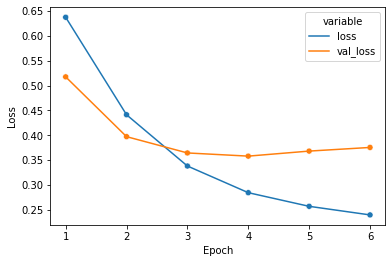

In [17]:
df_loss = df_history[['epoch', 'loss', 'val_loss']].melt(id_vars = ['epoch'])

sns.lineplot(x='epoch', y='value', data = df_loss, hue = 'variable')
sns.scatterplot(x='epoch',y='value', data = df_loss, hue = 'variable', legend = False)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

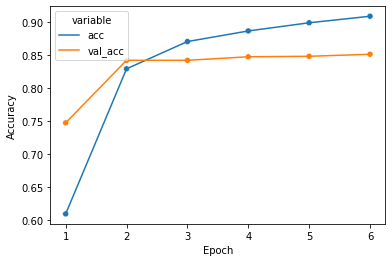

In [18]:
df_acc = df_history[['epoch', 'acc', 'val_acc']].melt(id_vars = ['epoch'])

sns.lineplot(x='epoch', y='value', data = df_acc, hue = 'variable')
sns.scatterplot(x='epoch',y='value', data = df_acc, hue = 'variable', legend = False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Model Evaluation

We have evaluated the model during the training, but we will look further at the recall and precision.

In [19]:
pred_test = model.predict(x_test_token)
pred_test = np.round(pred_test)

pred_test[0:5]

array([[1.],
       [1.],
       [0.],
       [0.],
       [1.]], dtype=float32)

Let's check the confusion matrix. The model have approximately the same amount of misclassified tweets for each class.

In [20]:
confusion_matrix(y_test, pred_test)

array([[1318,  192],
       [ 198,  917]])

Let's check some of the false positive.

In [21]:
df_pred = pd.DataFrame({'tweet': x_test, 'actual': y_test, 'predicted' : pred_test.reshape(len(pred_test)).tolist()})

df_pred[ (df_pred['actual'] != df_pred['predicted']) & (df_pred['actual'] == 0)]

,tweet,actual,predicted
838,dari ngebunuh musuh dari ngebunuh minion dari ...,0,1.0
4660,jika dia tak menyukai kekuranganmu menjauh dan...,0,1.0
9381,hanya butuh laki setia bukan laki bajingan,0,1.0
10968,di dunia maya seseorg di nilai dr tulisannya j...,0,1.0
13136,kapan bib gk sabr nih mau potong onta buat mer...,0,1.0
...,...,...,...
11375,hamdalah kelar juga ini fitur keparat,0,1.0
5911,kasian fitriani nasib mu sm dg pendahulu hanya...,0,1.0
8714,yg sengsara kan si rais obral bacot mulu ga la...,0,1.0
335,kan emang gw dongo,0,1.0


The tweets that has false positive (should be negative but predicted positive by the model) has a lot of similarity with a hate speech tweet, even for me personally some of this should be a hate speech.

Finally, let's check the accuracy, recall, precision, and the F1 score as well.

In [22]:
print("Accuracy: %.3f" %accuracy_score(y_test, pred_test))
print("Recall: %.3f" %recall_score(y_test, pred_test))
print("Precision: %.3f" %precision_score(y_test, pred_test))
print("F1 Score: %.3f" %f1_score(y_test, pred_test))

Accuracy: 0.851
Recall: 0.822
Precision: 0.827
F1 Score: 0.825
